In [1]:
# ! pip install super-gradients

In [2]:
from PIL import Image
import os
import numpy as np
import torch

import random
import pathlib

from torch.utils.data import Dataset
import json
from torchvision import transforms, utils


import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt


import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

2024-04-20 23:52:02.556999: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 23:52:03.021127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 23:52:03.901880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-04-20 23:52:06] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/iec-ptit/sg_logs/console.log


[2024-04-20 23:52:07] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


# Config

In [6]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'smoke_detection' #specify the experiment name

    #dataset params
    DATA_DIR = '../../dataset/wildfire_smoke_dataset/' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['smoke'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':8,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

# Exploring images

In [7]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 💾 Datasets and DataLoaders

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is. 

There are several well-known datasets for object detection, for example: 

- COCO
- Pascal
- YOLODarkNet
- YOLOv5

SuperGradients provides ready-to-use dataloaders for these datasets. If you're interested in learning more about working with `COCOFormatDetectionDataset` and the more general `DetectionDataset` [check out the SuperGradients documentation on this topic](https://docs.deci.ai/super-gradients/docstring/training/datasets/#training.datasets.detection_datasets.coco_detection.COCODetectionDataset)

You can learn more about working with SuperGradients datasets, dataloaders, and configuration files [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Data.md)

SuperGradients supports a number of dataset formats, you can learn more about that [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ObjectDetection.md)


In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-04-20 23:52:25] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 12280/12280 [00:07<00:00, 1654.92it/s]
[2024-04-20 23:52:33] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 3058/3058 [00:01<00:00, 2982.88it/s]
[2024-04-20 23:52:34] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  97%|█████████▋| 2970/3058 [00:00<00:00, 14777.31it/s]

Indexing dataset annotations: 100%|██████████| 3058/3058 [00:00<00:00, 14737.77it/s]


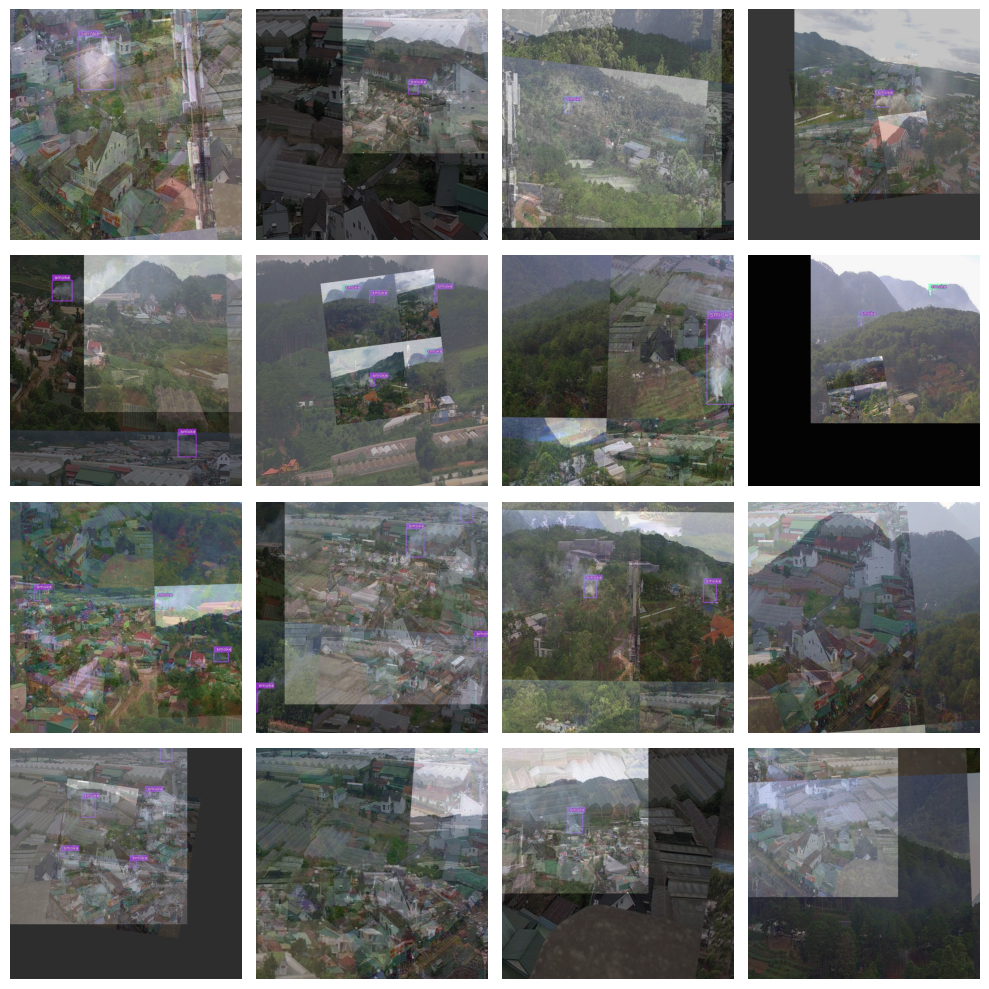

In [9]:
train_data.dataset.plot()

In [10]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2024-04-20 23:52:41] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-04-20 23:52:41] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-04-20 23:52:41] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [11]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050,DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr":1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-5,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0003},
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 2,
    "ema": True,
    "ema_params": {"decay": 0.999, "decay_type": "threshold"},
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=1,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=1,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ),
            # include_classwise_ap=True
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=1,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ),
            # include_classwise_ap=True
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [12]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2024-04-20 23:52:42] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240420_235242_348342`
[2024-04-20 23:52:42] INFO - sg_trainer.py - Checkpoints directory: checkpoints/smoke_detection/RUN_20240420_235242_348342
[2024-04-20 23:52:42] INFO - sg_trainer.py - Using EMA with params {'decay': 0.999, 'decay_type': 'threshold'}
/home/iec-ptit/anaconda3/envs/yolonas/lib/python3.9/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/iec-ptit/anaconda3/envs/yolonas/lib/python3.9/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning ra

The console stream is now moved to checkpoints/smoke_detection/RUN_20240420_235242_348342/console_Apr20_23_52_42.txt


[2024-04-20 23:52:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            10439      (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             2          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1304       (len(train_loader))
    - Gradient updates per epoch:   652        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 5e-05 (66.91M parameters) WD: 0.0, (84.69K parameters), WD: 0.0003, (66.82M parameters)

[2024-04-20 23:52:44] INFO - sg_trainer.py - Started training for 15

Train epoch 0:  11%|█         | 143/1304 [00:52<07:04,  2.74it/s, PPYoloELoss/loss=3.85, PPYoloELoss/loss_cls=1.83, PPYoloELoss/loss_dfl=0.872, PPYoloELoss/loss_iou=1.15, gpu_mem=6.84]
[2024-04-20 23:53:36] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2024-04-20 23:53:36] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2024-04-20 23:53:36] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [ ]:
# train_data.dataset.transforms.pop(3)
train_data.dataset.transforms.pop(2)
# train_data.dataset.transforms.pop(1)
# train_data.dataset.transforms.pop(0)

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050,DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr":5e-6,
    "lr_warmup_epochs": 0,
    "initial_lr": 5e-6,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.001},
    "zero_weight_decay_on_bias_and_bn": True,
#     "batch_accumulate": 1,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=1,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=1,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ),
            # include_classwise_ap=True
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=1,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ),
            # include_classwise_ap=True
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
run_ids = os.listdir(os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME))
try:
    for run_id in run_ids:
        best_model = models.get(config.MODEL_NAME,
                                num_classes=config.NUM_CLASSES,
                                checkpoint_path=os.path.join('./',config.CHECKPOINT_DIR, config.EXPERIMENT_NAME,run_id, 'ckpt_best.pth'))
except:
    pass

In [ ]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050,DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr":1e-6,
    "lr_warmup_epochs": 0,
    "initial_lr": 1e-6,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 1.0,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0003},
    "zero_weight_decay_on_bias_and_bn": True,
#     "batch_accumulate": 1,
    "ema": True,
    "ema_params": {"decay": 0.999, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=1,
#         reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=1,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ),
            # include_classwise_ap=True
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=1,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ),
            # include_classwise_ap=True
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

In [ ]:
try:
    run_ids = [id for id in os.listdir(os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME)) if id not in run_ids]
    for run_id in run_ids:
        best_model = models.get(config.MODEL_NAME,
                            num_classes=config.NUM_CLASSES,
                            checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME,run_id, 'average_model.pth'))
except:
    pass

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=config.NUM_CLASSES, 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))